In [1]:
# imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import pingouin as pg
import h5_utilities_module as h5u
import statsmodels.api as sm
from tqdm import tqdm
from scipy.stats import zscore
from scipy import stats
from scipy.signal import butter, filtfilt, hilbert
from astropy.stats import rayleightest

In [2]:
def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1
        
    new_state_details = get_state_magnitudes(state_details, indata)

    return new_state_details, state_array


def get_state_magnitudes(state_details, indata):
    """This is a helpfer function for find_candidate_states that computes the magnitude of each candidate state. 

    Args:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.

    Returns:
        new_state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
    """
    
    new_state_details = np.zeros((len(state_details), 4))
    
    # loop over each state
    for i in range(len(state_details)):
        
        # pull the details of this particular state
        i_trial_num = int(state_details[i, 0])
        i_start_ix = int(state_details[i, 1])
        i_duration = int(state_details[i, 2])
        
        new_state_details[i, 0] = i_trial_num
        new_state_details[i, 1] = i_start_ix
        new_state_details[i, 2] = i_duration

        new_state_details[i, 3] = np.nanmean(indata[i_trial_num, i_start_ix:i_start_ix+i_duration])
        
    return new_state_details
        

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM, percentile, or bootstrapped CI for input array, disregarding NaN values.
    Works with both 1D and 2D arrays.
    
    Parameters:
    - data: numpy array (1D or 2D)
    - type: str, either 'sem', 'percentile', or 'bootstrap'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap')
    - alpha: float, significance level for the confidence interval
    
    Returns:
    - means: numpy array containing means (scalar for 1D input, 1D array for 2D input)
    - interval: numpy array containing intervals (scalar for 1D input, 1D array for 2D input)
    """
    # Convert 1D array to 2D array with shape (n, 1)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    nan_mask = ~np.isnan(data)
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.nanmean(np.array([
            np.abs(nanmean_result - np.nanpercentile(data, 5, axis=0)),
            np.abs(nanmean_result - np.nanpercentile(data, 95, axis=0))
        ]))
        
    elif type == 'bootstrap':
        n_rows = data.shape[0]
        n_cols = data.shape[1]
        bootstrap_means = np.zeros((num_samples, n_cols))
        
        for col in range(n_cols):
            valid_data = data[:, col][nan_mask[:, col]]
            if len(valid_data) > 0:
                # Adjust sample size to match number of valid data points
                bootstrap_samples = np.random.choice(
                    valid_data,
                    size=(num_samples, len(valid_data)),
                    replace=True
                )
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan
        
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([
            abs(bootstrap_means - ci_lower),
            abs(bootstrap_means - ci_upper)
        ], axis=0)
        
        interval = np.nanmean(interval, axis=0)
    else:
        raise ValueError("Invalid 'type' argument. Use 'sem', 'percentile', or 'bootstrap'.")
    
    # If input was 1D, return scalar results
    if data.shape[1] == 1:
        nanmean_result = nanmean_result[0]
        interval = interval[0]
    
    return nanmean_result, interval

def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def get_instantaneous_LFP_measures(data, fs, freq_low, freq_high, order=3):
    """
    Apply bandpass filter and get instantaneous phase, amplitude, and filtered signal
    
    Parameters:
    -----------
    data : array-like, shape [n_trials, n_times]
        LFP data
    fs : float
        Sampling frequency in Hz
    freq_low : float
        Lower frequency bound for bandpass
    freq_high : float
        Upper frequency bound for bandpass
    order : int, optional
        Filter order (default=3)
        
    Returns:
    --------
    phase : array-like, shape [n_trials, n_times]
        Instantaneous phase at each timepoint (-π to π)
    amplitude : array-like, shape [n_trials, n_times]
        Instantaneous amplitude at each timepoint
    filtered : array-like, shape [n_trials, n_times]
        Bandpass filtered signal
    """
    # Create bandpass filter
    nyq = fs / 2
    low = freq_low / nyq
    high = freq_high / nyq
    b, a = butter(order, [low, high], btype='band')
    
    # Initialize output arrays
    phase = np.zeros_like(data)
    amplitude = np.zeros_like(data)
    filtered_signal = np.zeros_like(data)
    
    # Apply filter and get measures for each trial
    for i in range(data.shape[0]):
        # Bandpass filter the data
        filtered_signal[i,:] = filtfilt(b, a, data[i,:])
        # Get analytic signal using Hilbert transform
        analytic_signal = hilbert(filtered_signal[i,:])
        # Extract instantaneous phase
        phase[i,:] = np.angle(analytic_signal)
        # Extract instantaneous amplitude
        amplitude[i,:] = np.abs(analytic_signal)
    
    return phase, amplitude, filtered_signal


def compute_plv(phase_data):
    """
    Compute Phase Locking Value across trials at each timestep
    
    Parameters:
    -----------
    phase_data : array-like, shape [n_trials, n_times]
        Phase values in radians for each trial and timepoint
    
    Returns:
    --------
    plv : array-like, shape [n_times]
        Phase Locking Value at each timepoint
    """
    # Convert phase angles to complex numbers (Euler's formula)
    complex_phase = np.exp(1j * phase_data)
    
    # Take mean across trials (first dimension)
    # Absolute value of mean gives PLV
    plv = np.abs(np.nanmean(complex_phase, axis=0))
    
    return plv

def watson_williams_test(*args):
    """
    Perform Watson-Williams test to compare two or more circular distributions.
    
    Parameters:
    *args : array-like
        Two or more arrays containing angles in radians
        
    Returns:
    float : F-statistic
    float : p-value
    dict  : Additional test statistics
    
    Note: This test assumes the von Mises distribution and equal concentration parameters.
    """
    
    # Validate input
    if len(args) < 2:
        raise ValueError("At least two samples are required")
    
    # Calculate total number of observations
    N = sum(len(sample) for sample in args)
    k = len(args)  # number of groups
    
    # Calculate R (resultant length) for each group
    R_i = [np.sqrt((np.sum(np.cos(sample)))**2 + 
                   (np.sum(np.sin(sample)))**2) 
           for sample in args]
    
    # Calculate mean direction for each group
    theta_bar_i = [np.arctan2(np.sum(np.sin(sample)),
                             np.sum(np.cos(sample)))
                   for sample in args]
    
    # Calculate pooled R
    R = np.sqrt((sum(R_i[i] * np.cos(theta_bar_i[i]) for i in range(k)))**2 +
                (sum(R_i[i] * np.sin(theta_bar_i[i]) for i in range(k)))**2)
    
    # Calculate pooled mean direction
    theta_bar = np.arctan2(sum(R_i[i] * np.sin(theta_bar_i[i]) for i in range(k)),
                          sum(R_i[i] * np.cos(theta_bar_i[i]) for i in range(k)))
    
    # Calculate concentration parameter estimate
    kappa = (N - k) * R / (N - R)
    
    # Calculate test statistic
    F = ((N - k) * (sum(R_i) - R)) / ((k - 1) * (N - sum(R_i)))
    
    # Calculate degrees of freedom
    df1 = k - 1
    df2 = N - k
    
    # Calculate p-value
    p_value = 1 - stats.f.cdf(F, df1, df2)
    
    # Additional statistics for return
    additional_stats = {
        'group_means': theta_bar_i,
        'group_resultants': R_i,
        'pooled_mean': theta_bar,
        'pooled_resultant': R,
        'concentration': kappa,
        'df': (df1, df2)
    }
    
    return F, p_value, additional_stats

In [3]:
# where are the data?
decoder_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'


# get their relevant paths
decoder_files = h5u.find_h5_files(decoder_dir)
data_files = h5u.find_h5_files(data_dir)

In [4]:
file2use = 1

# load data for this file

# load the OFC decoder traces
ofc_ch = h5u.pull_from_h5(decoder_files[file2use], 'OFC_ch')
ofc_unch = h5u.pull_from_h5(decoder_files[file2use], 'OFC_unch')
ofc_alt_ch = h5u.pull_from_h5(decoder_files[file2use], 'OFC_alt_ch')
ofc_alt_unch = h5u.pull_from_h5(decoder_files[file2use], 'OFC_alt_unch')

# load the OFC LFP
ofc_lfp = np.clip(h5u.pull_from_h5(data_files[file2use], 'OFC_lfp'), -1e6, 1e6)
ofc_lfp = ofc_lfp[:,:, 0:384]
lfp_ts = h5u.pull_from_h5(data_files[file2use], 'lfp_ts')

# zscore the lfp data
ofc_lfp = ((ofc_lfp - np.nanmean(ofc_lfp.reshape(-1, ofc_lfp.shape[2]), axis=0)) / np.nanstd(ofc_lfp.reshape(-1, ofc_lfp.shape[2]), axis=0)).reshape(ofc_lfp.shape)

# take the mean across all channels
ofc_lfp = np.nanmean(ofc_lfp, axis=2)

# load the behavior
bhv = pd.read_hdf(decoder_files[file2use], 'bhv')

ofc_lfp = ofc_lfp[0:len(bhv), :]

# retain only the trials where the monkey made the right choice
trials2use = bhv['picked_best'] == 1
ofc_ch = ofc_ch[trials2use, :]
ofc_unch = ofc_unch[trials2use, :]
ofc_alt_ch = ofc_alt_ch[trials2use, :]
ofc_alt_unch = ofc_alt_unch[trials2use, :]
ofc_lfp = ofc_lfp[trials2use, :]
bhv = bhv.loc[trials2use]


C:\Users\thome\AppData\Local\Temp\ipykernel_2592\1910387983.py:20: RuntimeWarning: Mean of empty slice
  ofc_lfp = np.nanmean(ofc_lfp, axis=2)


In [5]:
# identify the states based on these criteria
mag_thresh = 2 # how many times above the noise a state must be
time_thresh = 2 # how many consecutive time bins must the state be above that noise-multiple threshold?
n_classes = 12

ofc_ch_details, ofc_ch_states = find_candidate_states(ofc_ch, n_classes, time_thresh, mag_thresh)
ofc_unch_details, ofc_unch_states  = find_candidate_states(ofc_unch, n_classes, time_thresh, mag_thresh)
ofc_alt_ch_details, ofc_alt_ch_states  = find_candidate_states(ofc_alt_ch, n_classes, time_thresh, mag_thresh)
ofc_alt_unch_details, ofc_alt_unch_states  = find_candidate_states(ofc_alt_unch, n_classes, time_thresh, mag_thresh)

# get states during the choice period
t_thresh1 = 40
t_thresh2 = 56

ofc_ch_choice = ofc_ch_details[(ofc_ch_details[:, 1] > t_thresh1) & (ofc_ch_details[:, 1] < t_thresh2)]
ofc_unch_choice = ofc_unch_details[(ofc_unch_details[:, 1] > t_thresh1) & (ofc_unch_details[:, 1] < t_thresh2)]
ofc_alt_ch_choice = ofc_alt_ch_details[(ofc_alt_ch_details[:, 1] > t_thresh1) & (ofc_alt_ch_details[:, 1] < t_thresh2)]
ofc_alt_unch_choice = ofc_alt_unch_details[(ofc_alt_unch_details[:, 1] > t_thresh1) & (ofc_alt_unch_details[:, 1] < t_thresh2)]

In [10]:
# find the duration of each state
ofc_ch_dur = []
ofc_unch_dur = []
ofc_alt_ch_dur = []
ofc_alt_unch_dur = []

for t in range(len(bhv)):

    # was there an OFC ch state on this trial?
    ofc_ch_ix = ofc_ch_choice[:, 0] == t
    ofc_ch_dur.append(np.vstack((
           ofc_ch_choice[ofc_ch_ix, 1]*25, # state onset time relative to pics on
           ofc_ch_choice[ofc_ch_ix, 2]*25, # state duration
           np.ones((np.sum(ofc_ch_ix), ))*t, 
           np.ones((np.sum(ofc_ch_ix), ))*bhv['state'].iloc[t], 
           np.ones((np.sum(ofc_ch_ix), ))*bhv['n_sacc'].iloc[t])).T)
    
    # was there an OFC unch state on this trial?
    ofc_unch_ix = ofc_unch_choice[:, 0] == t
    ofc_unch_dur.append(np.vstack((
        ofc_unch_choice[ofc_unch_ix, 1]*25, # state onset time relative to pics on
        ofc_unch_choice[ofc_unch_ix, 2]*25, # state duration
           np.ones((np.sum(ofc_unch_ix), ))*t, 
           np.ones((np.sum(ofc_unch_ix), ))*bhv['state'].iloc[t], 
           np.ones((np.sum(ofc_unch_ix), ))*bhv['n_sacc'].iloc[t])).T)
    
    # was there an OFC alt_ch state on this trial?
    ofc_alt_ch_ix = ofc_alt_ch_choice[:, 0] == t
    ofc_alt_ch_dur.append(np.vstack((
        ofc_alt_ch_choice[ofc_alt_ch_ix, 1]*25, # state onset time relative to pics on
        ofc_alt_ch_choice[ofc_alt_ch_ix, 2]*25, # state duration
           np.ones((np.sum(ofc_alt_ch_ix), ))*t, 
           np.ones((np.sum(ofc_alt_ch_ix), ))*bhv['state'].iloc[t], 
           np.ones((np.sum(ofc_alt_ch_ix), ))*bhv['n_sacc'].iloc[t])).T)
    
    # was there an OFC alt_unch state on this trial?
    ofc_alt_unch_ix = ofc_alt_unch_choice[:, 0] == t
    ofc_alt_unch_dur.append(np.vstack((
        ofc_alt_unch_choice[ofc_alt_unch_ix, 1]*25, # state onset time relative to pics on
        ofc_alt_unch_choice[ofc_alt_unch_ix, 2]*25, # state duration
           np.ones((np.sum(ofc_alt_unch_ix), ))*t, 
           np.ones((np.sum(ofc_alt_unch_ix), ))*bhv['state'].iloc[t], 
           np.ones((np.sum(ofc_alt_unch_ix), ))*bhv['n_sacc'].iloc[t])).T)
    
# convert back to numpy arrays
ofc_ch_dur = np.concatenate(ofc_ch_dur, axis=0) 
ofc_unch_dur = np.concatenate(ofc_unch_dur, axis=0) 
ofc_alt_ch_dur = np.concatenate(ofc_alt_ch_dur, axis=0) 
ofc_alt_unch_dur = np.concatenate(ofc_alt_unch_dur, axis=0) 

# create one big array
all_ofc_dur = np.vstack((ofc_ch_dur, ofc_alt_unch_dur))


In [11]:
# now loop through the big array of states and get the alpha phase at each onset time

# bandpass the LFP into the theta, alpha, and beta ranges
theta_phase, theta_amp, theta_wave = get_instantaneous_LFP_measures(ofc_lfp, 1000, 4, 8, 3)
alpha_phase, alpha_amp, alpha_wave = get_instantaneous_LFP_measures(ofc_lfp, 1000, 12, 20, 3)
beta_phase, beta_amp, beta_wave = get_instantaneous_LFP_measures(ofc_lfp, 1000, 20, 30, 3)

# initialize an array to accumulate data into
state_phase = np.zeros((len(all_ofc_dur), 3))

# loop over each state and get the phase at the onset of the state
for s in range(len(all_ofc_dur)):

    lfp_ts_ix = np.argmin(np.abs(lfp_ts - all_ofc_dur[s, 1]))
    state_phase[s, 0] = theta_phase[int(all_ofc_dur[s, 2]), lfp_ts_ix]
    state_phase[s, 1] = alpha_phase[int(all_ofc_dur[s, 2]), lfp_ts_ix]
    state_phase[s, 2] = beta_phase[int(all_ofc_dur[s, 2]), lfp_ts_ix]

In [12]:
dur_single_ix = (all_ofc_dur[:, 3] < 3) & (all_ofc_dur[:, 4] == 1)
dur_double_ix = (all_ofc_dur[:, 3] < 3) & (all_ofc_dur[:, 4] == 2)

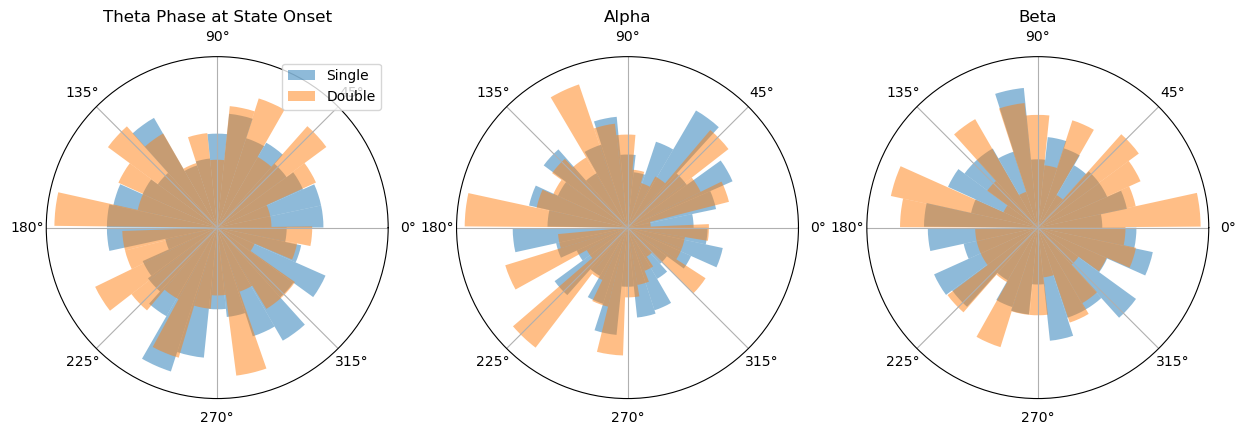

In [13]:
# For multiple distributions on same plot:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='polar'))


ax[0].hist(state_phase[dur_single_ix, 0], alpha=0.5, bins=30, label='Single', density=True)
ax[0].hist(state_phase[dur_double_ix, 0], alpha=0.5, bins=30, label='Double', density=True)
ax[0].set_rticks([])  # This removes the radial ticks
ax[0].set_title('Theta Phase at State Onset')

ax[1].hist(state_phase[dur_single_ix, 1], alpha=0.5, bins=30, label='Single', density=True)
ax[1].hist(state_phase[dur_double_ix, 1], alpha=0.5, bins=30, label='Double', density=True)
ax[1].set_rticks([])  # This removes the radial ticks
ax[1].set_title('Alpha')

ax[2].hist(state_phase[dur_single_ix, 2], alpha=0.5, bins=30, label='Single', density=True)
ax[2].hist(state_phase[dur_double_ix, 2], alpha=0.5, bins=30, label='Double', density=True)
ax[2].set_rticks([])  # This removes the radial ticks
ax[2].set_title('Beta')

ax[0].legend()
